In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
from IPython.display import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision

In [2]:
new_size = 448
N = 7
num_of_clusters = 13
slice_size = new_size // N
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
device

device(type='cpu')

In [3]:
path_to_imgs = '/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images'
path = os.path.join(path_to_imgs, r'train_images')
img_ids = os.listdir(path)
files = [os.path.join(path, f) for f in img_ids]
path_to_bb_file = '/kaggle/input/textocr-text-extraction-from-images-dataset'
path_to_bounding_boxes = os.path.join(path_to_bb_file, r'TextOCR_0.1_train.json')
with open(path_to_bounding_boxes, 'r') as f:
    bounding_boxes = json.load(f)

In [4]:
def pad_img(img):
    """
    Pad image to square using pytorch, to the right or bottom
    """
    h, w = img.shape[-2:]
    if h > w:
        pad = h - w
        img = transforms.Pad((0, 0, pad, 0))(img)
    elif w > h:
        pad = w - h
        img = transforms.Pad((0, 0, 0, pad))(img)
    return img

def resize_img(img, size):
    """
    Resize image to square using pytorch
    """
    img = transforms.Resize(size, antialias=True)(img)
    return img

torch.Size([3, 768, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 448, 448])


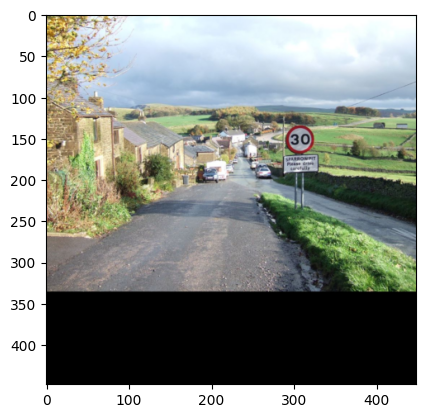

In [5]:
def make_it_cv2(img):
    img = img.permute(1, 2, 0)
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

img = read_image(files[7])
print(img.shape)
img = pad_img(img)
print(img.shape)
img = resize_img(img, (new_size, new_size))
print(img.shape)
img = make_it_cv2(img)
cv2.imwrite('test.jpg', img)
plt.imshow(img)

In [6]:
def pre_process_image(img):
    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1)
    elif img.shape[0] != 3:
        img = img[:3]
    h, w = img.shape[-2:]
    max_shape = max(h, w)
    ratio = new_size / max_shape
    img = pad_img(img)
    img = resize_img(img, (new_size, new_size))
    img = img/255.
    img = img.float()
    return img, ratio


tensor([[[0.1451, 0.1255, 0.0941,  ..., 0.2157, 0.2196, 0.2078],
         [0.1490, 0.1294, 0.1059,  ..., 0.2157, 0.2196, 0.2078],
         [0.1412, 0.1216, 0.0980,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.5804, 0.5608, 0.5373,  ..., 0.6118, 0.6118, 0.6157],
         [0.5686, 0.5608, 0.5451,  ..., 0.6196, 0.6235, 0.6353],
         [0.5529, 0.5529, 0.5333,  ..., 0.6275, 0.6353, 0.6510]],

        [[0.1098, 0.0902, 0.0627,  ..., 0.1216, 0.1255, 0.1137],
         [0.1098, 0.0941, 0.0706,  ..., 0.1216, 0.1255, 0.1137],
         [0.1020, 0.0863, 0.0667,  ..., 0.1216, 0.1255, 0.1176],
         ...,
         [0.4275, 0.4157, 0.4000,  ..., 0.4941, 0.4941, 0.4980],
         [0.4235, 0.4235, 0.4157,  ..., 0.4980, 0.5020, 0.5137],
         [0.4157, 0.4157, 0.4000,  ..., 0.5059, 0.5137, 0.5294]],

        [[0.0745, 0.0627, 0.0471,  ..., 0.0745, 0.0784, 0.0667],
         [0.0745, 0.0667, 0.0549,  ..., 0.0745, 0.0784, 0.0667],
         [0.0667, 0.0627, 0.0510,  ..., 0.0745, 0.0745, 0.

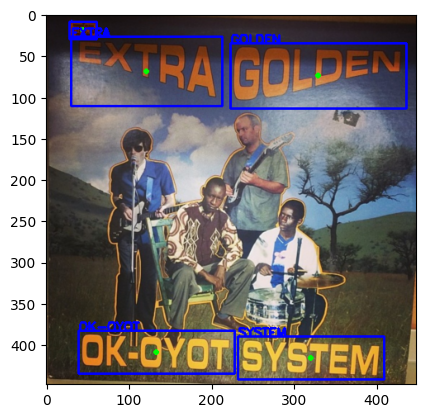

In [7]:
def get_bbox_resized(prebb, ratio):
    bb = prebb.copy()
    bb[0] = bb[0] * ratio
    bb[1] = bb[1] * ratio
    bb[2] = bb[2] * ratio
    bb[3] = bb[3] * ratio
    return bb
def get_middle_point(bb):
    x = (bb[0] + bb[2])/2
    y = (bb[1] + bb[3])/2
    return [x, y]
img_idx = 0
img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
img = read_image(files[img_idx])
img, ratio = pre_process_image(img)
print(img)
# img *= 255
img = make_it_cv2(img)
for i in range(len(img_anns)):
    ann = bounding_boxes['anns'][img_anns[i]]
    points = ann['bbox']
    x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
    x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    middle_point = get_middle_point([x1, y1, x2, y2])
    cv2.circle(img, (int(middle_point[0]), int(middle_point[1])), 2, (0, 255, 0), 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(img, str(ann['utf8_string']), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
cv2.imwrite('img_with_annotations.jpg', img)
plt.imshow(img)

In [8]:
idx_to_remove = []
for img_idx in range(len(files)):
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        idx_to_remove.append(img_idx)
        continue

print('Number of images before removing images with no annotations: {}'.format(len(files)))
files = [i for j, i in enumerate(files) if j not in idx_to_remove]
img_ids = [i for j, i in enumerate(img_ids) if j not in idx_to_remove]
print('Number of images after removing images with no annotations: {}'.format(len(files)))

Number of images before removing images with no annotations: 25119
Number of images after removing images with no annotations: 21778


In [9]:
files = np.array(files)
img_ids = np.array(img_ids)
max_point_in_slice = 1
os.chdir('/kaggle')
os.mkdir('tmp')
os.chdir('tmp')
os.mkdir('data')
os.chdir('data')
os.mkdir('features')
os.mkdir('labels')

data_set_size = 50
imgpath_label = []

def create_examples(size=len(files)):
    for idx in range(size):
        img_path = files[idx + 6000]

        imgpath_label.append(img_path)
#         torchvision.io.write_jpeg(image, os.path.join('features', str(idx)))
#         torch.save(image, os.path.join('features', img_ids[len(img_ids) - idx][:-4] + '.pt'))
        print(f'\r{idx + 1}/{len(files)}', end='', flush=True)

create_examples(data_set_size)

50/21778

In [69]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

class CustomImageDataset(Dataset):
    def __init__(self, size):
        self.size = size

    def __len__(self):
        return len(imgpath_label)

    def __getitem__(self, idx):
        image = read_image(imgpath_label[idx])
#         feature, ratio = pre_process_image(image)
        
        return image  #, ratio
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
    
dataset = CustomImageDataset(img_ids[-data_set_size:])
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=os.cpu_count())

def get_batch(b):
    output = []
    b_iter = iter(dataset)
    for i in range(b):
        output.append(next(b_iter))
    return output

print(len(dataloader))

50


torch.Size([1, 3, 1024, 683])


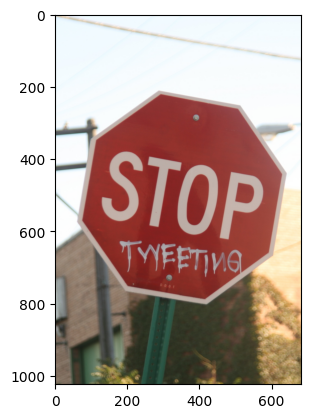

In [11]:
img_example = next(iter(dataloader))
print(img_example.shape)
img_example = make_it_cv2(img_example[0])
plt.imshow(img_example)

In [12]:
dropout = 0.0
factor = 1

class VggBlock(nn.Module):
    def __init__(self, in_ch, out_ch, maxpool=True):
        super(VggBlock, self).__init__()
        block = []
        for i in range(len(in_ch)):
            block.append(nn.Conv2d(in_ch[i], out_ch[i], kernel_size=3, padding=1, bias=False))
            block.append(nn.BatchNorm2d(out_ch[i]))
            block.append(nn.LeakyReLU(0.1, inplace=True))
            block.append(nn.Dropout2d(dropout, inplace=False))
        if maxpool:
            block.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        block_modules = nn.ModuleList(block)
        self.block = nn.Sequential(*block_modules)

    def forward(self, x):
        x = self.block(x)
        return x
    
class Vgg(nn.Module):
    def __init__(self):
        super(Vgg, self).__init__()
        self.conv1 = VggBlock([3, int(64*factor)], [int(64*factor), int(64*factor)])
        self.conv2 = VggBlock([int(64*factor), int(128*factor)], [int(128*factor), int(128*factor)])
        self.conv3 = VggBlock([int(128*factor), int(256*factor), int(256*factor)], [int(256*factor), int(256*factor), int(256*factor)])
        self.conv4 = VggBlock([int(256*factor), int(512*factor), int(512*factor)], [int(512*factor), int(512*factor), int(512*factor)])
        self.conv5 = VggBlock([int(512*factor), int(512*factor), int(512*factor)], [int(512*factor), int(512*factor), int(512*factor)])
        self.conv6 = VggBlock([int(512*factor), int(512*factor), int(512*factor)], [int(512*factor), int(512*factor), int(512*factor)], False)
        
    def forward(self, x):
        x = self.conv1(x)
        x1 = self.conv2(x)
        x2 = self.conv3(x1)
        x3 = self.conv4(x2)
        x4 = self.conv5(x3)
        x5 = self.conv6(x4)
        return x1, x2, x3, x4, x5
    
class Upconv(nn.Module):
    def __init__(self,in_ch, out_ch, upsample=True):
        super(Upconv, self).__init__()
        self.upsample = upsample
        layer = []
        layer.append(nn.Conv2d(in_ch, out_ch*2, kernel_size=1, padding=0, bias=False))
        layer.append(nn.BatchNorm2d(out_ch*2))
        layer.append(nn.LeakyReLU(0.1, inplace=True))
        layer.append(nn.Dropout2d(dropout, inplace=False))
        layer.append(nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1, bias=False))
        layer.append(nn.BatchNorm2d(out_ch))
        layer.append(nn.LeakyReLU(0.1, inplace=True))
        layer.append(nn.Dropout2d(dropout, inplace=False))
        
        layer_modules = nn.ModuleList(layer)
        self.layer = nn.Sequential(*layer_modules)
        
    def forward(self, x):
        if self.upsample:
            size = x.size()[2:]
            size = (size[0]*2, size[1]*2)
            x = nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=False)
        x = self.layer(x)
        return x


class Model(nn.Module):
    def __init__(self, img_size, N, max_points_in_slice):
        super(Model, self).__init__()
        self.img_size = img_size
        self.N = N
        self.max_points_in_slice = max_points_in_slice
        self.vgg = Vgg()
        self.upconv1 = Upconv(int(1024*factor), int(256*factor))
        self.upconv2 = Upconv(int(768*factor), int(128*factor))
        self.upconv3 = Upconv(int(384*factor), int(64*factor))
        self.upconv4 = Upconv(int(192*factor), int(64*factor), True)
        self.conv_last = nn.Sequential(
            nn.Conv2d(int(64*factor), int(64*factor), kernel_size=3, padding=1), nn.BatchNorm2d(int(64*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(64*factor), int(64*factor), kernel_size=3, padding=1), nn.BatchNorm2d(int(64*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(64*factor), int(32*factor), kernel_size=3, padding=1), nn.BatchNorm2d(int(32*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(32*factor), int(32*factor), kernel_size=1), nn.BatchNorm2d(int(32*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(32*factor), 1, kernel_size=1)
        )
        

    def forward(self, x):
        vgg_outputs = self.vgg(x)
        y1 = torch.cat([vgg_outputs[3], vgg_outputs[4]], dim=1)
        y1 = self.upconv1(y1)
        
        y2 = torch.cat([y1, vgg_outputs[2]], dim=1)
        y2 = self.upconv2(y2)
        
        y3 = torch.cat([y2, vgg_outputs[1]], dim=1)
        y3 = self.upconv3(y3)
        
        y4 = torch.cat([y3, vgg_outputs[0]], dim=1)
        y4 = self.upconv4(y4)
        
        y = self.conv_last(y4)
        y = y.view(-1, new_size//2, new_size//2)

        return y

In [14]:
detection_model = Model(new_size, N, num_of_clusters)
detection_model = nn.DataParallel(detection_model, device_ids=[0])
checkpoint = torch.load('/kaggle/input/detection-model/saved_model (13).pth', map_location=torch.device('cpu'))
detection_model.load_state_dict(checkpoint)
for parameter in detection_model.parameters():
    parameter.requires_grad = False
detection_model.to(device)

DataParallel(
  (module): Model(
    (vgg): Vgg(
      (conv1): VggBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1, inplace=True)
          (3): Dropout2d(p=0.0, inplace=False)
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): LeakyReLU(negative_slope=0.1, inplace=True)
          (7): Dropout2d(p=0.0, inplace=False)
          (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (conv2): VggBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.

In [15]:
from scipy import ndimage

def from_Tensor2BB(segmentation_maps, ratios, threshold=0.5):
    batches = []
    for i in range(len(segmentation_maps)):

        current_seg = segmentation_maps[i]
        current_seg = (current_seg - current_seg.min()) / (current_seg.max() - current_seg.min())
        
        binary_mask = current_seg > threshold

        labeled_mask, num_labels = ndimage.label(binary_mask)

        bounding_boxes = ndimage.find_objects(labeled_mask)
        bbs = []

        for label, bbox in enumerate(bounding_boxes, start=1):
            if bbox is not None:
                y1, y2, x1, x2 = bbox[0].start, bbox[0].stop, bbox[1].start, bbox[1].stop
                bbs.append((0, int(x1*2/ratios[i]), int(y1*2/ratios[i]), int(x2*2/ratios[i]), int(y2*2/ratios[i])))
        batches.append(bbs)

    return batches

In [16]:
dropout = 0.4

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

class Patches(nn.Module):
    def __init__(self, ph, pw, in_ch):
        super(Patches, self).__init__()
        self.ph = ph
        self.pw = pw
        self.ln = nn.LayerNorm(ph*pw*in_ch)
        
    def forward(self, x):
        b, c, h, w = x.shape
        nh, nw = h // self.ph, w // self.pw
        x = torch.reshape(x, (b, c, nh, self.ph, nw, self.pw))
        x = torch.permute(x, (0, 2, 4, 3, 5, 1))
        x = torch.reshape(x, [b, nh * nw, self.ph * self.pw * c])
        x = self.ln(x)
        return x
    
class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, block_size, n_embed):
        super(CharacterEmbedding, self).__init__()
        self.block_size = block_size
        self.token_embed_tab = nn.Embedding(vocab_size, n_embed)
        self.register_buffer(
                    "positional_embeddings",
                    get_positional_embeddings(block_size, n_embed),
                    persistent=False,
                )
        
    def forward(self, x):
        # x shape: (batch, block_size)
        B, T = x.shape
        x = self.token_embed_tab(x) # shape: (batch, block_size, n_embed)
        position_embed = self.positional_embeddings[:T, :]
        return x + position_embed.repeat(x.shape[0], 1, 1)
    
class PatchEmbedding(nn.Module):
    def __init__(self, n_patches, patch_size, n_embed, add_patches=0):
        super(PatchEmbedding, self).__init__()
        self.n_patches = n_patches
        self.token_embed_tab = nn.Linear(patch_size, n_embed)
        self.positional_embeddings = nn.Parameter(torch.randn(1, n_patches + add_patches + 1, n_embed)*0.02)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, n_embed))
        self.dropout = nn.Dropout(0.)
        if add_patches > 0:
            self.add_patches = nn.Parameter(torch.zeros(1, add_patches, n_embed))
        else:
            self.add_patches = None
        
    def forward(self, x):
        B = x.shape[0]
        x = self.token_embed_tab(x)
        cls_tok = self.cls_token.expand([B, -1, -1])
        x = torch.cat([cls_tok, x], dim=1)
        if self.add_patches != None:
            new_patches = self.add_patches.expand([B, -1, -1])
            x = torch.cat([x, new_patches], dim=1)
        x = x + self.positional_embeddings.repeat(B, 1, 1)
        x = self.dropout(x)
        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, block_size, n_embed, apply_mask, cross=False):
        super(MultiHeadAttention, self).__init__()
        self.single_head_size = n_embed // n_heads
        self.n_heads = n_heads
        self.out = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)
        self.apply_mask = apply_mask
        self.attn_weights = None
        if apply_mask:
            self.register_buffer('mask', torch.tril(torch.ones(block_size, block_size)))
        self.cross = cross
        if cross:
            self.kv = nn.Linear(n_embed, 2*n_embed, bias=False)
            self.q = nn.Linear(n_embed, n_embed, bias=False)
        else:
            self.qkv = nn.Linear(n_embed, 3*n_embed, bias=False)
        
    def forward(self, x, kv=None):
        B, T, C = x.shape
        if self.cross:
            k, v = self.kv(kv).reshape(B, kv.shape[1], 2, self.n_heads, self.single_head_size).permute(2, 0, 3, 1, 4).unbind(0) # (2, B, n_heads, T, head_dim)
            q = self.q(x).reshape(B, T, self.n_heads, self.single_head_size).permute(0, 2, 1, 3)
        else:
            q, k, v = self.qkv(x).reshape(B, T, 3, self.n_heads, self.single_head_size).permute(2, 0, 3, 1, 4).unbind(0)
        q = q * (self.single_head_size ** -0.5)
        attn = q @ k.transpose(-2, -1)
        if self.apply_mask:
            attn = attn.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn.detach().cpu().numpy()
        x = attn @ v
        x = x.transpose(1, 2).reshape(B, T, C)
        x = self.dropout(self.out(x))
        return x
    
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super(FeedForward, self).__init__()
        layers = [nn.Linear(n_embed, 4*n_embed),
                  nn.GELU(),
                  nn.Linear(4*n_embed, n_embed),
                  nn.Dropout(dropout)]
        layer_modules = nn.ModuleList(layers)
        self.net = nn.Sequential(*layer_modules)
        
    def forward(self, x):
        return self.net(x)

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.15):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output
    
class EncoderBlock(nn.Module):
    def __init__(self, n_heads, block_size, n_embed):
        super(EncoderBlock, self).__init__()
        self.self_attention = MultiHeadAttention(n_heads, block_size, n_embed, False)
        self.fw = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.layer_scale1 = nn.Parameter(1e-5 * torch.ones(n_embed))
        self.layer_scale2 = nn.Parameter(1e-5 * torch.ones(n_embed))
        self.drop_path = DropPath()
        
    def forward(self, x):
        x = x + self.drop_path(self.layer_scale1*self.self_attention(self.ln1(x)))
        x = x + self.drop_path(self.layer_scale2*self.fw(self.ln2(x)))
        return x
    
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, block_size, n_embed):
        super(DecoderBlock, self).__init__()
        self.masked_self_attention = MultiHeadAttention(n_heads, block_size, n_embed, True)
        self.cross_attention = MultiHeadAttention(n_heads, block_size, n_embed, False, True)
        self.fw = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)
        layer_scale = False
        self.layer_scale1 = nn.Parameter(1e-5 * torch.ones(n_embed)) if layer_scale else nn.Identity()
        self.layer_scale2 = nn.Parameter(1e-5 * torch.ones(n_embed)) if layer_scale else nn.Identity()
        self.layer_scale3 = nn.Parameter(1e-5 * torch.ones(n_embed)) if layer_scale else nn.Identity()
        self.drop_path = DropPath()
        
    def forward(self, x):
        x, kv = x[0], x[1]
        x = x + self.drop_path(self.layer_scale1(self.masked_self_attention(self.ln1(x))))
        x = x + self.drop_path(self.layer_scale2(self.cross_attention(self.ln2(x), kv)))
        x = x + self.drop_path(self.layer_scale3(self.fw(self.ln3(x))))
        return (x, kv)
    
class Encoder(nn.Module):
    def __init__(self, N, n_heads, block_size, n_embed):
        super(Encoder, self).__init__()
        self.blocks = [EncoderBlock(n_heads, block_size, n_embed) for _ in range(N)]
        self.blocks = nn.ModuleList(self.blocks)
        self.blocks = nn.Sequential(*self.blocks)
        
    def forward(self, x):
        return self.blocks(x)
    
class Decoder(nn.Module):
    def __init__(self, N, n_heads, block_size, n_embed):
        super(Decoder, self).__init__()
        self.blocks = [DecoderBlock(n_heads, block_size, n_embed) for _ in range(N)]
        self.blocks = nn.ModuleList(self.blocks)
        self.blocks = nn.Sequential(*self.blocks)
    
    def forward(self, x, kv):
        return self.blocks((x, kv))
    
class TrOcr(nn.Module):
    def __init__(self):
        super(TrOcr, self).__init__()
        n_embed = 384
        L_en = 12
        L_de = 4
        n_heads = 12
        patch_h = 16
        patch_w = 16
        h = 128
        w = 32
        ch = 1
        self.seq_len = 27
        n_patches = w*h//(patch_h*patch_w)
        patch_size = w*h*ch//n_patches
        add_patches = 0
        self.to_patches = Patches(patch_h, patch_w, ch)
        self.patch_embedding = PatchEmbedding(n_patches, patch_size, n_embed, add_patches)
        self.token_embedding = CharacterEmbedding(len(vocab), self.seq_len, n_embed)
        self.encoder = Encoder(L_en, n_heads, n_patches, n_embed)
        self.decoder = Decoder(L_de, n_heads, self.seq_len, n_embed)
        self.ln = nn.LayerNorm(n_embed)
        self.last_layer = nn.Linear(n_embed, len(vocab))
        
    def forward(self, x, de_input):
        en_output = self.to_patches(x)
        en_output = self.patch_embedding(en_output)
        en_output = self.encoder(en_output)
        de_input = self.token_embedding(de_input)
        de_output = self.decoder(de_input, en_output)
        output = self.ln(de_output[0])
        output = output[:, :self.seq_len]
        B, T, E = output.shape
        output = output.reshape(B*T, E)
        output = self.last_layer(output).view(B, T, len(vocab))
        return output

In [17]:
chars = set()
for img_idx in range(len(img_ids)):
    img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    for idx in range(len(img_anns)):
        ann = bounding_boxes['anns'][img_anns[idx]]
        for char in ann['utf8_string']:
            chars.add(char)
pad_token = '█'
start_token = '├'
end_token = '┤'
chars.add(pad_token)
chars.add(start_token)
chars.add(end_token)
vocab = sorted(list(chars))
print(len(vocab))
print(vocab)

903
['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '£', '¥', '§', '©', '«', '¬', '®', '°', '±', '²', '³', 'µ', '·', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'ċ', 'Č', 'č', 'Đ', 'Ē', 'ē', 'Ĕ', 'ĕ', 'Ė', 'ė', 'Ę',

In [18]:
recognition_model = TrOcr()
recognition_model = nn.DataParallel(recognition_model, device_ids=[0])
checkpoint = torch.load('/kaggle/input/recognition-model/saved_model (9).pth', map_location=torch.device('cpu'))
recognition_model.load_state_dict(checkpoint)
for parameter in recognition_model.parameters():
    parameter.requires_grad = False
recognition_model.to(device)

DataParallel(
  (module): TrOcr(
    (to_patches): Patches(
      (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embedding): PatchEmbedding(
      (token_embed_tab): Linear(in_features=256, out_features=384, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (token_embedding): CharacterEmbedding(
      (token_embed_tab): Embedding(903, 384)
    )
    (encoder): Encoder(
      (blocks): Sequential(
        (0): EncoderBlock(
          (self_attention): MultiHeadAttention(
            (out): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.4, inplace=False)
            (qkv): Linear(in_features=384, out_features=1152, bias=False)
          )
          (fw): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=384, out_features=1536, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=1536, out_features=384, bias=True)
              (3

In [19]:
chtoi = {ch: i for i, ch in enumerate(vocab)}
itoch = {i: ch for i, ch in enumerate(vocab)}

def encode(s: str):
    encoded = []
    for c in s:
        encoded.append(chtoi[c])
    return encoded

def decode(d: list):
    decoded = ""
    for i in d:
        if type(i) == torch.Tensor:
            decoded += itoch[i.item()]
        else:
            decoded += itoch[i]
    return decoded

pad_token_en = encode(pad_token)[0]
print(encode("heyyyy"))
print(decode(encode("heyyyy")))

[71, 68, 88, 88, 88, 88]
heyyyy


In [20]:
from torchvision.transforms import v2

def pre_process_text_box(img):
    img = transforms.Resize((32, 128), antialias=True)(img)
    img = v2.Grayscale()(img)
    img = img / 255.
    return img

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [21]:
def trim_pad(s):
    idx = s.index(end_token, 1)
    return s[1:idx]

In [40]:
def get_text_bb(img, bbs, t=0.6):
    recognition_model.eval()
    B = len(bbs)
    i_end_token = encode(end_token)[0]
    i_pad_token = encode(pad_token)[0]
#     output = []
    croped_ls = []
    for i in range(B):
        _, x1, y1, x2, y2 = bbs[i]
        croped = img[y1:y2, x1:x2]
        croped = torch.tensor(croped)
        croped = croped.permute(2, 0, 1)
        croped = pre_process_text_box(croped)
        croped = croped.view(1, 32, 128)
        croped_ls.append(croped)
    features = torch.cat(croped_ls, axis=0)
    features = features.to(device)
    
    current_token = [start_token for i in range(B)]
    current_de_string = torch.tensor(encode(start_token)[0], dtype=torch.long).view(1, 1).expand(B, -1)
    features = features.view(B, 1, 32, 128)
    idx = 0
    confidences = [0 for i in range(B)]
    n_characters = [0 for i in range(B)]
    remaining_words_to_predict = [i for i in range(B)]
#     first_token_val = []
    while idx < 27:
        current_de_string.to(device)
        with torch.autocast('cuda'):
            predictions = recognition_model.forward(features, current_de_string)
        predictions = nn.functional.softmax(predictions, dim=-1)
        current_token = torch.argmax(predictions, dim=-1)[:, idx].cpu()
#         if idx == 0:
#             first_token_val = torch.max(predictions, dim=-1)
#             confidences = [confidences[i] + first_token_val[0][i][0] for i in range(B)]
            
        for j in range(B):
            if current_token[i] == i_end_token:
                if j in remaining_words_to_predict:
                    remaining_words_to_predict.remove(j)
            
        first_token_val = torch.max(predictions, dim=-1)
        confidences = [confidences[i] + first_token_val[0][i][0] if i in remaining_words_to_predict else confidences[i] for i in range(B)]
        n_characters = [n_characters[i] + 1 if i in remaining_words_to_predict else n_characters[i] for i in range(B)]
        
        
        
        current_de_string = torch.cat([current_de_string, current_token.view(B, 1)], dim=-1)
        idx += 1
    confidences = [confidences[i]/n_characters[i] for i in range(B)]
#     print(confidences)
    output = [(bbs[i], trim_pad(decode(current_de_string[i]))) for i in range(B) if confidences[i] > t]
    return output
#     axs[i, j].set_title(f"Predicted: {decode(current_de_string[0])}\nTrue: {trim_pad(decode(test_label))}")
#     axs[i, j].imshow(make_it_cv2(test_feature[0].cpu()))
    

In [63]:
dataloader_gen = iter(dataloader)

In [24]:
def draw_text(img, text,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=2,
          font_thickness=2,
          text_color=(0, 255, 0),
          text_color_bg=(100, 100, 100)
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size

In [73]:
detection_model.eval()
raw_images = get_batch(50)
test_features = [pre_process_image(raw_images[i]) for i in range(len(raw_images))]
ratios = [tf[1] for tf in test_features]
test_features = torch.cat([tf[0].view(1, tf[0].shape[0], tf[0].shape[1], tf[0].shape[2]) for tf in test_features], axis=0)
print(test_features.shape)
if len(test_features.shape) == 3:
    test_features = test_features.view(1, test_features.shape[0], test_features.shape[1], test_features.shape[2])
test_features = test_features.to(device)
with torch.autocast('cuda'):
    predictions = detection_model.forward(test_features)

torch.Size([50, 3, 448, 448])


/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [97]:
predictions_bb = from_Tensor2BB(predictions.detach().cpu().numpy(), ratios, 0.85)
idx = -1

>
new
university
americans
impact
P
Sun
nevi
Stadium


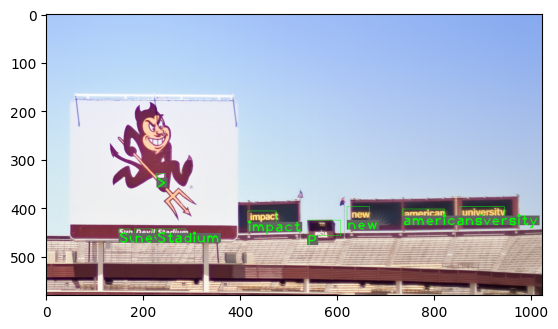

In [143]:
idx += 1
raw_image = raw_images[idx].cpu()
img = make_it_cv2(raw_image)

bounding_boxes_preds = predictions_bb[idx]
bbs_text = get_text_bb(img, bounding_boxes_preds, t=0.3)
for (box, text) in bbs_text:
    _, x1, y1, x2, y2 = box
#     if max(x2 - x1, y2 - y1) < 30:
#         continue 
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    org = (x1, y2)
    draw_text(img, text, pos=org)
    print(text)
    
cv2.imwrite('/kaggle/working/test.jpg', img)
plt.imshow(img)


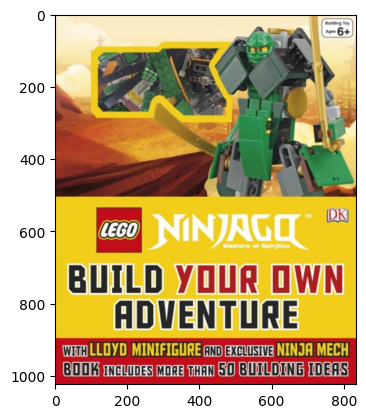

In [133]:
plt.imshow(raw_images[idx].permute(1, 2, 0))

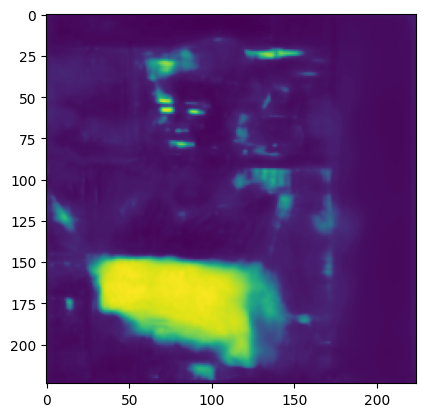

In [117]:
current_seg = predictions[idx]
current_seg = (current_seg - current_seg.min()) / (current_seg.max() - current_seg.min())
# current_seg = current_seg > 0.85
plt.imshow(current_seg)